In [2]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print('Path Dataset berada di :', path)
print('Isi folder :', os.listdir(path))

Using Colab cache for faster access to the 'airlines-flights-data' dataset.
Path Dataset berada di : /kaggle/input/airlines-flights-data
Isi folder : ['airlines_flights_data.csv', '.nfs00000000397759a600000068']


In [3]:
import pandas as pd

df = pd.read_csv(path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [4]:
df.drop(columns='index', inplace=True)
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

**PREPROCESSING**

In [6]:
Features = ['source_city', 'departure_time','stops','arrival_time','destination_city','class','days_left']

In [7]:
Fitur = df[Features]
Target = df['price']

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(
    Fitur, Target, test_size=0.2, random_state=42
)

In [9]:
print(f"Data Training berjumlah :{len(X_train)} dan Data Uji berjumlah : {len(X_test)}")

Data Training berjumlah :240122 dan Data Uji berjumlah : 60031


In [10]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

scaler = StandardScaler()
num_feat = ['days_left']
num_transform = scaler

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_feat = ['source_city','departure_time','stops','arrival_time','destination_city']
cat_transform = encoder

In [12]:
ordinal_features = ['class']
class_categories = ['Economy','Business']
ordinal_transform = OrdinalEncoder(categories=[class_categories])

In [13]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('log', log_transform),
        ('scaler', num_transform)]),num_feat),
    ('ord', ordinal_transform, ordinal_features),
    ('cat', cat_transform, cat_feat)
], remainder='drop')

In [15]:
from sklearn.linear_model import Lasso

model = Lasso()

In [22]:
from sklearn.compose import TransformedTargetRegressor

pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor= model,
        func= np.log1p,
        inverse_func=np.expm1
    ))
])

In [23]:
params_grid = {
    'regressor__regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

**HYPERPARAMETER TUNING**

In [24]:
from sklearn.model_selection import GridSearchCV

grid_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=params_grid,
    cv = 5,
    scoring= 'r2',
    n_jobs=-1,
    verbose=1
)

In [25]:
grid_lasso.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['days_left']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Business']]),
                                                                         ['class']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['source_city',
                                                                          'departure_time',
                                                                          'stops',
                                                                          'arrival_time',
                                                                          'destination_city'])])),
                                       ('regressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=Lasso()))]),
             n_jobs=-1,
             param_grid={'regressor__regressor__alpha': [0.001, 0.01, 0.1, 1,
                                                         10, 100]},
             scoring='r2', verbose=1)

In [26]:
best_model = grid_lasso.best_estimator_

**EVALUATE**

In [27]:
print('Best params lasso :', grid_lasso.best_params_)
print('Best CV Score :', grid_lasso.best_score_)

Best params lasso : {'regressor__regressor__alpha': 0.01}
Best CV Score : 0.8561946567982858


In [28]:
print(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_left']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('cat',
                   

In [30]:
y_pred = best_model.predict(X_test)

In [32]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print('=== HASIL EVALUASI MODEL TERHADAP DATA UJI ===')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Hasil rmse model lasso adalah {rmse:.4f}')
print(f'Hasil mae model lasso adalah {mae:.4f}')
print(f'Hasil r2 model lasso adalah {r2:.4f}')
print(f'Harga Aktual pada data uji : \n {y_test.values}')
print(f'Harga Prediksi pada data uji : \n {np.round(y_pred,2)}')

=== HASIL EVALUASI MODEL TERHADAP DATA UJI ===
Hasil rmse model lasso adalah 8587.3957
Hasil mae model lasso adalah 4947.2333
Hasil r2 model lasso adalah 0.8569
Harga Aktual pada data uji : 
 [ 7366 64831  6195 ...  6734  5082 66465]
Harga Prediksi pada data uji : 
 [ 5259.44 44404.14  5429.61 ...  5584.78  3296.44 84597.25]


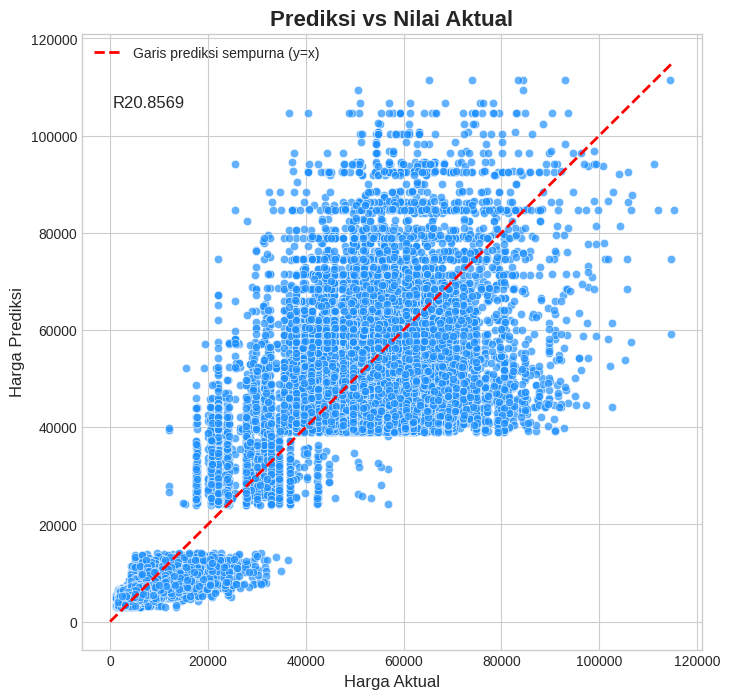

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val],[0, max_val], 'r--', lw=2, label='Garis prediksi sempurna (y=x)')
plt.title('Prediksi vs Nilai Aktual', fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual',fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05, 0.9, f'R2{r2:.4f}', transform=plt.gca(). transAxes, fontsize=12, verticalalignment='top')
plt.show()

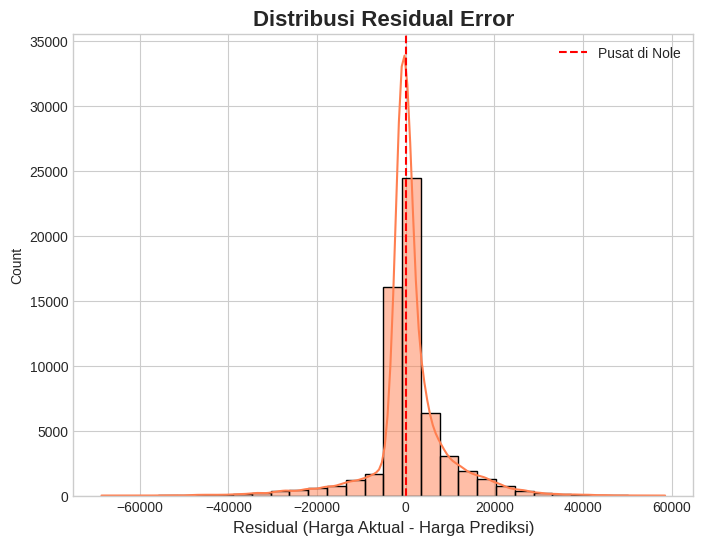

In [35]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Residual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residual (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nole')
plt.legend()
plt.show()

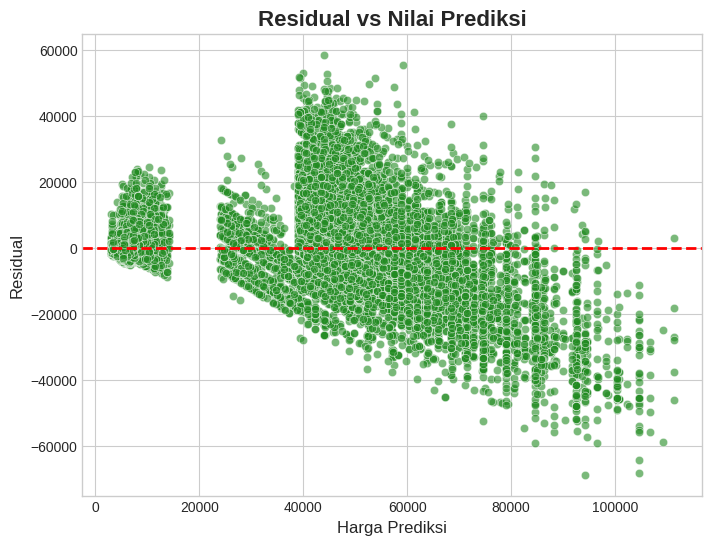

In [36]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()

In [45]:
# Mengambil langkah preprocessor dan regressornya

preprocessor = best_model.named_steps['preprocessor']
regressor = best_model.named_steps['regressor'].regressor_ # Ditambahkan karena regressor di dalam TransformedTargetResessor

In [46]:
features_name =[]

# Numeric
num_features = preprocessor.transformers_[0][2]
features_name.extend(num_features)

# Ordinal
ord_features = preprocessor.transformers_[1][2]
features_name.extend(ord_features)

# OneHotEncoder
cat_encoder = preprocessor.transformers_[2][1]
cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[2][2])
features_name.extend(cat_features)

In [47]:
# Buat DataFrame Feature Importancesnya

coef = regressor.coef_
feature_importance = pd.DataFrame({
    'Feature': features_name,
    'Coefficient': coef
})

In [48]:
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
feature_importance.head(10)

,Feature,Coefficient,Abs_Coefficient
1,class,2.108539,2.108539
16,stops_zero,-0.482801,0.482801
0,days_left,-0.211822,0.211822
6,source_city_Kolkata,0.081966,0.081966
27,destination_city_Kolkata,0.042719,0.042719
19,arrival_time_Evening,0.019481,0.019481
12,departure_time_Morning,0.003750,0.003750
15,stops_two_or_more,0.000052,0.000052
5,source_city_Hyderabad,-0.000000,0.000000
4,source_city_Delhi,-0.000000,0.000000


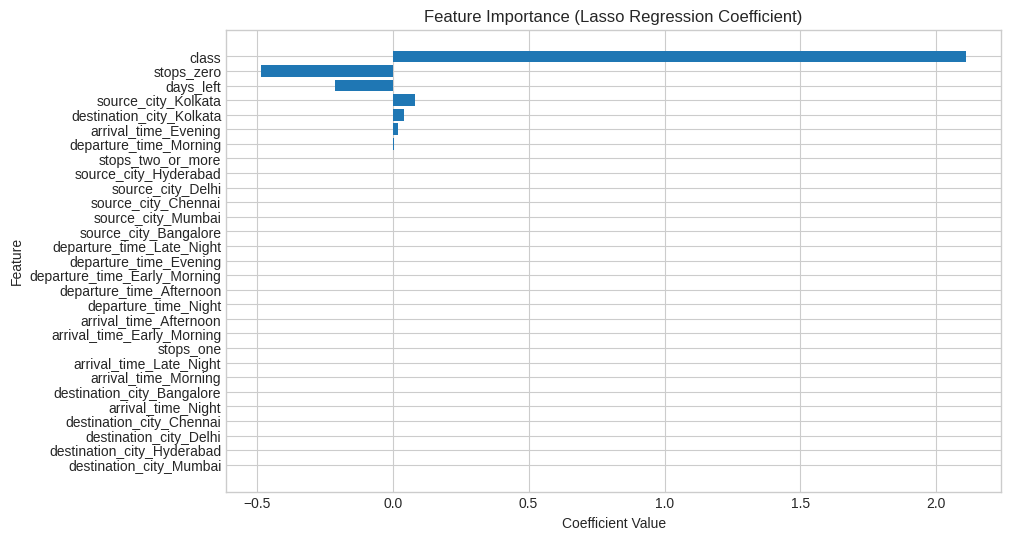

In [50]:
plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Lasso Regression Coefficient)')
plt.gca().invert_yaxis()
plt.show()

In [52]:
from google.colab import files
import joblib

joblib.dump(best_model, 'Lasso_regressor_predictions_flights_price.pkl')

['Lasso_regressor_predictions_flights_price.pkl']

In [53]:
files.download('Lasso_regressor_predictions_flights_price.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>